# **Challenge Nexialog**

#### Objectif du projet
<p style="text-align: justify;">
Des tests sont réalisés dans toutes les boxs, permettant d'identifier implicitement les interruptions de réseau.
L'objectif est de mettre en place une approche non supervisé pour détecter des futurs problèmes sur une partie du réseau → Détection « d’anneaux ». Il faut détecter les noeuds du réseau qui sont défaillants en essayant d’anticiper le plus possible à l’avance.
</p>


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px

### Importation

In [55]:
df = pd.read_parquet('data/250203_tests_fixe_dns_sah_202412_202501.parquet', engine="pyarrow")

## EDA

#### Exploration

In [56]:
print(df.shape)
df.head(2)

(9964847, 18)


,date_hour,code_departement,olt_model,olt_name,peag_nro,boucle,dsp,pebib,pop_dns,nb_test_dns,avg_dns_time,std_dns_time,nb_test_scoring,avg_latence_scoring,std_latence_scoring,avg_score_scoring,std_score_scoring,nb_client_total
0,2024-12-01,01,old0,01_olt_1,01_peag_1,BU966,dsp_1,69_pebib_1,69_lyon,61,4.888439,0.834768,25,10.4625,0.843750,2.852823,0.550380,86
1,2024-12-01,01,old0,01_olt_2,01_peag_2,BU966,dsp_1,21_pebib_2,69_lyon,60,6.341362,2.033462,18,11.0000,0.346331,3.100490,0.451774,78


In [57]:
df.tail(2)

,date_hour,code_departement,olt_model,olt_name,peag_nro,boucle,dsp,pebib,pop_dns,nb_test_dns,avg_dns_time,std_dns_time,nb_test_scoring,avg_latence_scoring,std_latence_scoring,avg_score_scoring,std_score_scoring,nb_client_total
9964845,2025-01-31 23:00:00,95,M24,95_olt_5630,95_peag_2919,BU24,dsp_1,92_pebib_11,77_mit,30,2.772375,0.311158,13,5.06250,0.607569,3.308824,0.436891,43
9964846,2025-01-31 23:00:00,95,M24,95_olt_5631,95_peag_2880,BU4,dsp_1,None,77_mit,8,3.761344,1.497898,2,4.78125,0.397748,3.538235,0.012478,10


C'est une période de tests de 2 mois avec une fréquence par heure

In [58]:
df.dtypes

date_hour              datetime64[ns]
code_departement               object
olt_model                      object
olt_name                       object
peag_nro                       object
boucle                         object
dsp                            object
pebib                          object
pop_dns                        object
nb_test_dns                     int64
avg_dns_time                  float64
std_dns_time                  float64
nb_test_scoring                 int64
avg_latence_scoring           float64
std_latence_scoring           float64
avg_score_scoring             float64
std_score_scoring             float64
nb_client_total                 int64
dtype: object

In [59]:
def afficher_pourcentage_valeurs_manquantes(df):
    pourcentage_manquantes = round(df.isna().mean() * 100, 2)
    pourcentage_manquantes = pourcentage_manquantes.sort_values(ascending=False)
    print("Pourcentage de valeurs manquantes par variable (en %) :\n")
    print(pourcentage_manquantes)

afficher_pourcentage_valeurs_manquantes(df)

Pourcentage de valeurs manquantes par variable (en %) :

pebib                  44.67
std_score_scoring      23.52
std_latence_scoring    23.52
std_dns_time            9.39
avg_latence_scoring     8.57
avg_score_scoring       8.57
avg_dns_time            7.85
pop_dns                 7.85
olt_model               0.09
date_hour               0.00
code_departement        0.00
nb_test_dns             0.00
peag_nro                0.00
boucle                  0.00
olt_name                0.00
dsp                     0.00
nb_test_scoring         0.00
nb_client_total         0.00
dtype: float64


Preprocessing de la date

In [60]:
df['date_hour'] = pd.to_datetime(df['date_hour'])
df['date_hour'].tail()

9964842   2025-01-31 23:00:00
9964843   2025-01-31 23:00:00
9964844   2025-01-31 23:00:00
9964845   2025-01-31 23:00:00
9964846   2025-01-31 23:00:00
Name: date_hour, dtype: datetime64[ns]

Modèles d'OLT :

In [61]:
df.olt_model.unique()

array(['old0', 'M11', 'M13', 'M20', 'M22', 'M24', 'old1', None],
      dtype=object)

**Observons les liens entre les différentes étapes du réseau**

In [62]:
df['OLT_PEAG_boucle'] = df['olt_name'] + df['peag_nro']  + df['boucle'] 

In [63]:
print('Nombre total de combinaisons OLT x PEAG x boucle :',df['OLT_PEAG_boucle'].nunique())
print('Nombre de noms de OLT :', df.olt_name.nunique())
print('Nombre de noms de PEAG :', df.peag_nro.nunique())
print('Nombre de noms de boucle :', df.boucle.nunique())
print('Nombre de noms de PEBIB :', df.pebib.nunique())
print('Nombre de noms de DSP :', df.dsp.nunique())


# print('Nombre de départements :', df.code_departement.nunique())

Nombre total de combinaisons OLT x PEAG x boucle : 6228
Nombre de noms de OLT : 6061
Nombre de noms de PEAG : 3176
Nombre de noms de boucle : 537
Nombre de noms de PEBIB : 211
Nombre de noms de DSP : 32


Nombre d'associations de chaque noeud à l'autre

In [64]:
print('Nombre d\'OLT par PEAG :', round(df.groupby('peag_nro')['olt_name'].nunique().mean(), 2))
print('Nombre de PEAG par boucle :', round(df.groupby('boucle')['peag_nro'].nunique().mean(), 2))
print('Nombre de boucle par PEBIB :', round(df.groupby('pebib')['boucle'].nunique().mean(), 2))
print('Nombre de PEBIB par DSP :', round(df.groupby('dsp')['pebib'].nunique().mean(), 2))

Nombre d'OLT par PEAG : 1.96
Nombre de PEAG par boucle : 5.94
Nombre de boucle par PEBIB : 3.64
Nombre de PEBIB par DSP : 8.12


Nombre de noeuds testés par heure

In [65]:
exemple_date_list = [
    '2024-12-30 23:00:00',
    '2025-01-14 01:00:00',
    '2025-01-01 10:00:00',
    '2024-12-17 12:00:00',
    '2024-12-12 07:00:00'
]

for date in exemple_date_list:
    df_exemple = df[df['date_hour'] == date].copy()
    print('Nombre de boucles testées le', date, ':')
    print('Nombre de lignes pour cette date :', len(df_exemple))
    print('Nombre total de boucles x PEAG x OLT :',df_exemple['OLT_PEAG_boucle'].nunique())
    print('Nombre de noms de OLT :', df_exemple.olt_name.nunique())
    print('Nombre de noms de PEAG :', df_exemple.peag_nro.nunique())
    print('Nombre de noms de PEBIB :', df_exemple.pebib.nunique())
    print('Nombre de noms de DSP :', df_exemple.dsp.nunique())
    print('-'*5)
    print('Nombre de départements :', df_exemple.code_departement.nunique())
    print('-'*50)
    

Nombre de boucles testées le 2024-12-30 23:00:00 :
Nombre de lignes pour cette date : 5737
Nombre total de boucles x PEAG x OLT : 5643
Nombre de noms de OLT : 5642
Nombre de noms de PEAG : 2969
Nombre de noms de PEBIB : 198
Nombre de noms de DSP : 31
-----
Nombre de départements : 96
--------------------------------------------------
Nombre de boucles testées le 2025-01-14 01:00:00 :
Nombre de lignes pour cette date : 5841
Nombre total de boucles x PEAG x OLT : 5759
Nombre de noms de OLT : 5759
Nombre de noms de PEAG : 3029
Nombre de noms de PEBIB : 198
Nombre de noms de DSP : 31
-----
Nombre de départements : 96
--------------------------------------------------
Nombre de boucles testées le 2025-01-01 10:00:00 :
Nombre de lignes pour cette date : 5835
Nombre total de boucles x PEAG x OLT : 5748
Nombre de noms de OLT : 5746
Nombre de noms de PEAG : 3011
Nombre de noms de PEBIB : 197
Nombre de noms de DSP : 31
-----
Nombre de départements : 96
-------------------------------------------

#### Data Analyse

**Obervons un seul OLT particulier**

In [66]:
olt_choisi = '01_olt_5'

In [67]:
df_one_olt = df[df['olt_name'] == olt_choisi]
print(df_one_olt.shape)
print('Nombre d\'heures :', df_one_olt['date_hour'].nunique())
df_one_olt.head()

(1632, 19)
Nombre d'heures : 1488


,date_hour,code_departement,olt_model,olt_name,peag_nro,boucle,dsp,pebib,pop_dns,nb_test_dns,avg_dns_time,std_dns_time,nb_test_scoring,avg_latence_scoring,std_latence_scoring,avg_score_scoring,std_score_scoring,nb_client_total,OLT_PEAG_boucle
4,2024-12-01 00:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,28,2.787241,0.410001,16,8.542969,0.512205,2.868750,0.714469,44,01_olt_501_peag_4BU458
5714,2024-12-01 01:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,48,2.567641,0.392563,18,8.250000,0.334175,3.100980,0.438691,66,01_olt_501_peag_4BU458
11443,2024-12-01 02:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,48,2.830063,1.234778,22,8.386364,0.384617,3.071390,0.521566,70,01_olt_501_peag_4BU458
17191,2024-12-01 03:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,16,2.784000,0.435983,15,8.700000,1.531150,2.958823,0.741271,31,01_olt_501_peag_4BU458
23333,2024-12-01 04:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,30,2.624050,0.383274,12,8.390625,0.289647,2.992647,0.533511,42,01_olt_501_peag_4BU458


24 h * 31 jours * 2 mois = 1488. Ici, on a 1632 lignes, observons pourquoi :

In [68]:
df_one_olt_duplicate = df_one_olt[df_one_olt['date_hour'].duplicated(keep=False)]
print('Nombre de lignes qui ont été dupliquées :', len(df_one_olt_duplicate))

Nombre de lignes qui ont été dupliquées : 288


Observons les lignes qui sont dupliquées :

In [69]:
df_one_olt_duplicate.sort_values(by='date_hour', inplace=True)
df_one_olt_duplicate.head()

C:\Users\lebre\AppData\Local\Temp\ipykernel_54504\2871594164.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date_hour,code_departement,olt_model,olt_name,peag_nro,boucle,dsp,pebib,pop_dns,nb_test_dns,avg_dns_time,std_dns_time,nb_test_scoring,avg_latence_scoring,std_latence_scoring,avg_score_scoring,std_score_scoring,nb_client_total,OLT_PEAG_boucle
1510907,2024-12-11 00:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,42,2.607143,0.442217,12,9.515625,5.005120,2.900000,0.799255,54,01_olt_501_peag_4BU458
1667099,2024-12-11 00:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,42,2.607143,0.442217,12,9.515625,5.005120,2.900000,0.799255,54,01_olt_501_peag_4BU458
1673602,2024-12-11 01:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,20,2.761162,0.307817,14,8.156250,0.480853,3.072479,0.524024,34,01_olt_501_peag_4BU458
1517410,2024-12-11 01:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,20,2.761162,0.307817,14,8.156250,0.480853,3.072479,0.524024,34,01_olt_501_peag_4BU458
1523940,2024-12-11 02:00:00,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,33,2.674273,0.605163,13,8.264423,0.422476,2.942308,0.449114,46,01_olt_501_peag_4BU458


Cela semble être des erreurs, le même test affiché plusieurs fois. Il faut donc les supprimer.

In [70]:
df_one_olt = df_one_olt.drop_duplicates(subset='date_hour', keep='first')
df_one_olt.shape

(1488, 19)

**Visualisations**

Ajout de colonnes

In [71]:
pio.renderers.default = 'notebook'
col_palette=['#5533FF','#19A368','#521265','#751818',"#FF5733",'#5533FF','#19A368','#5533FF','#19A368', '#521265']
col_to_plot = ['nb_test_dns', 'avg_dns_time', 'std_dns_time', 'nb_test_scoring', 'avg_latence_scoring',
       'std_latence_scoring', 'avg_score_scoring', 'std_score_scoring', 'nb_client_total']

Lineplots

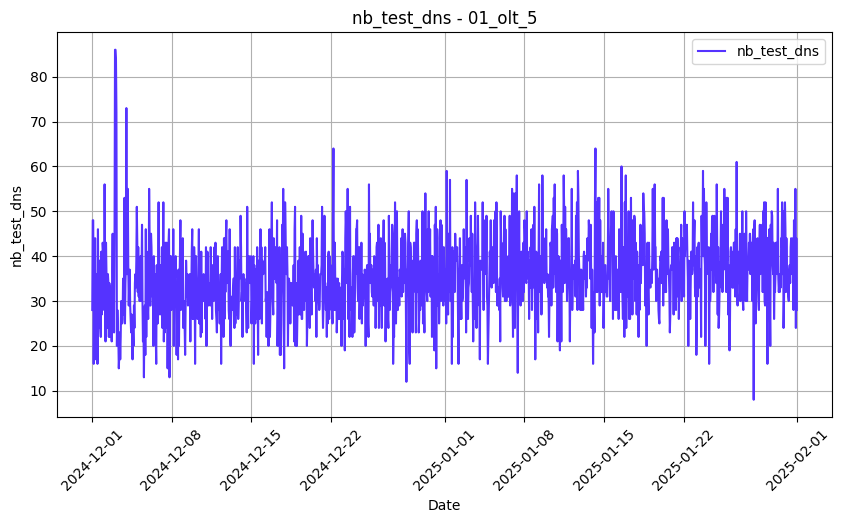

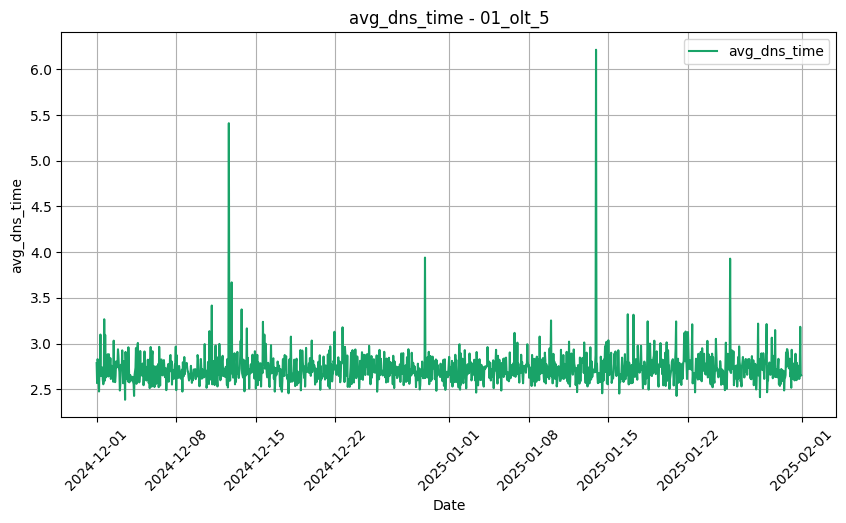

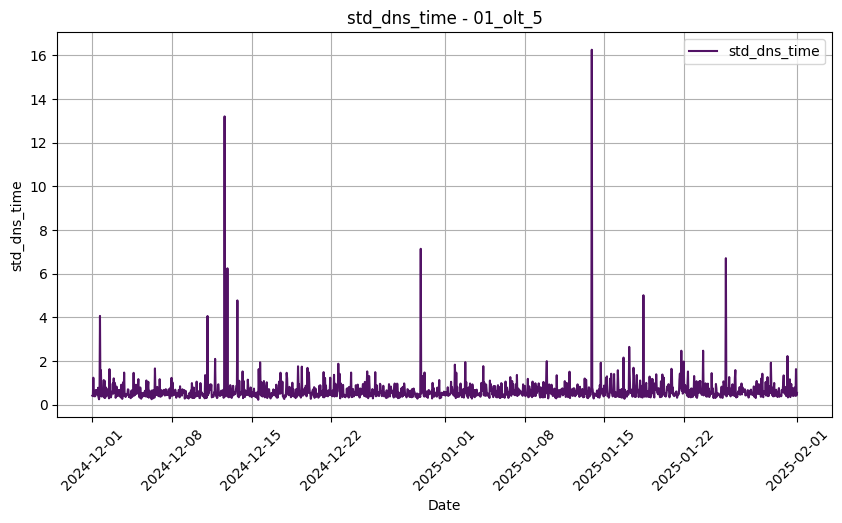

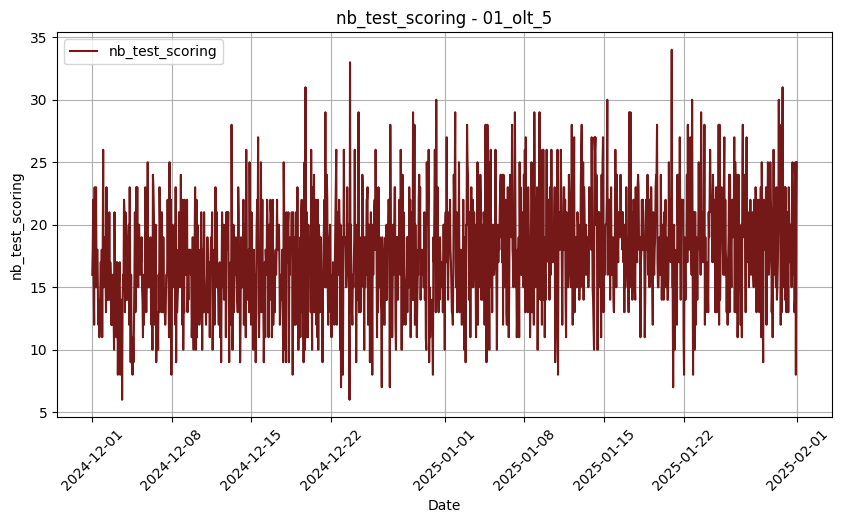

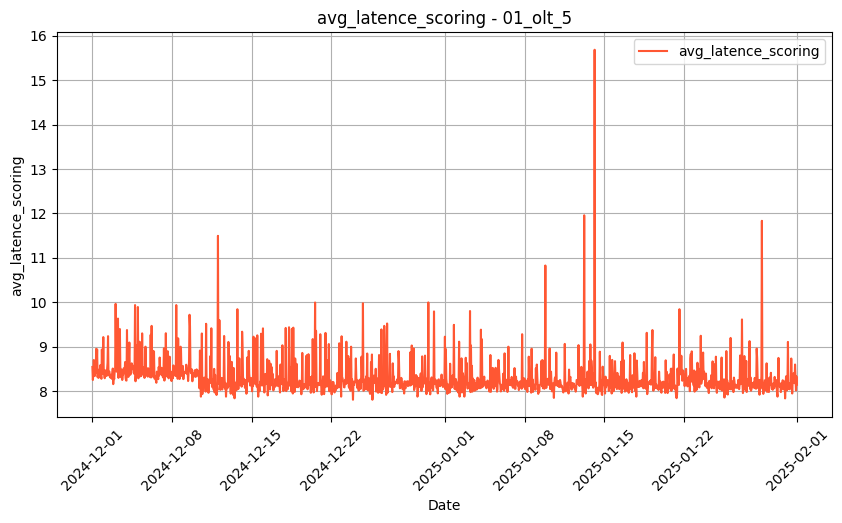

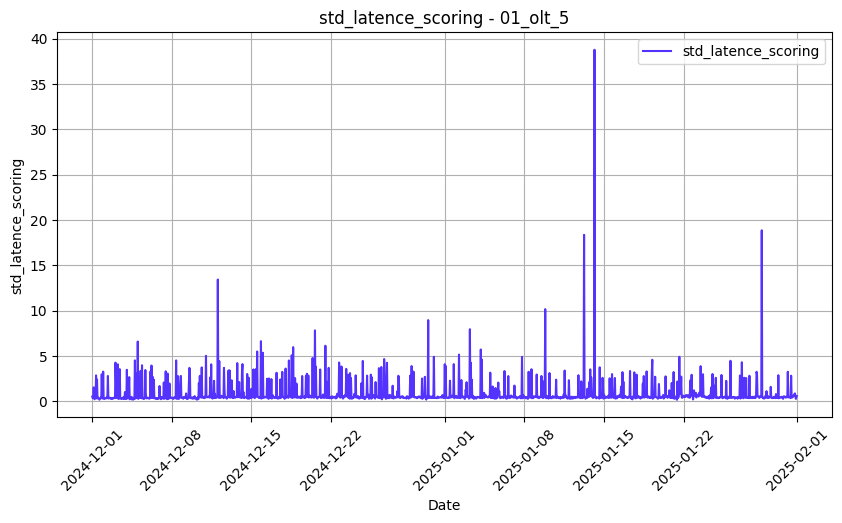

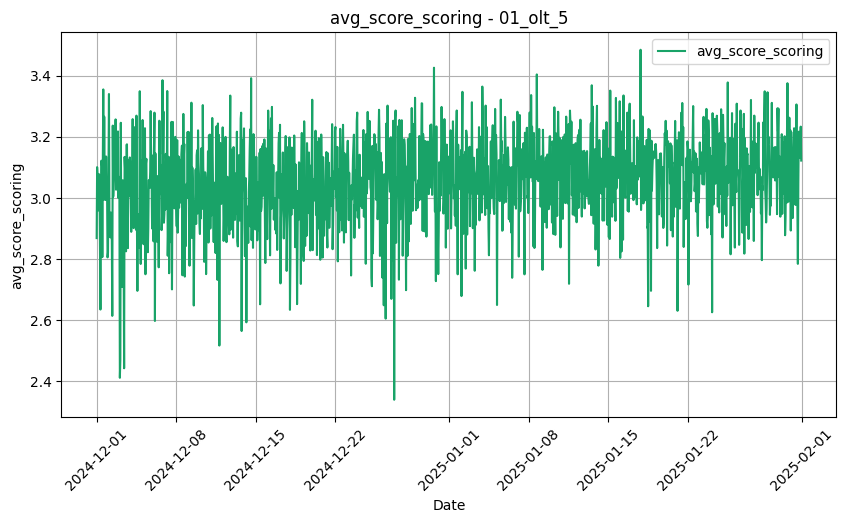

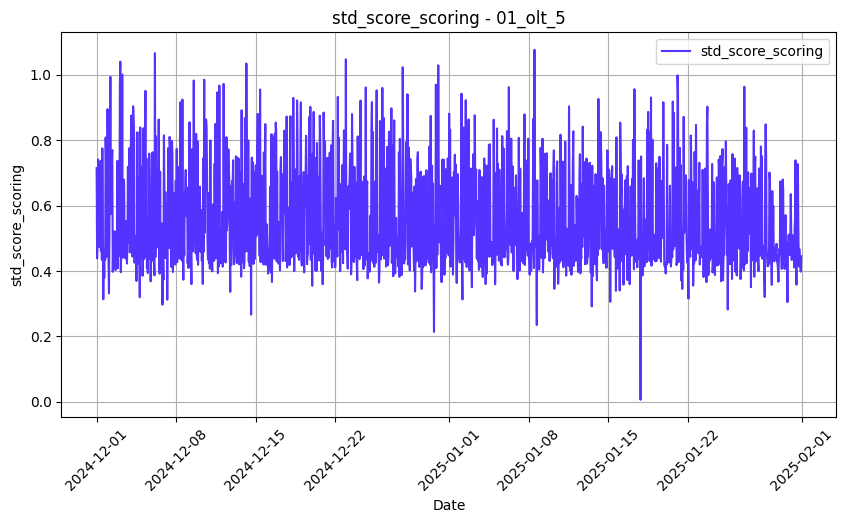

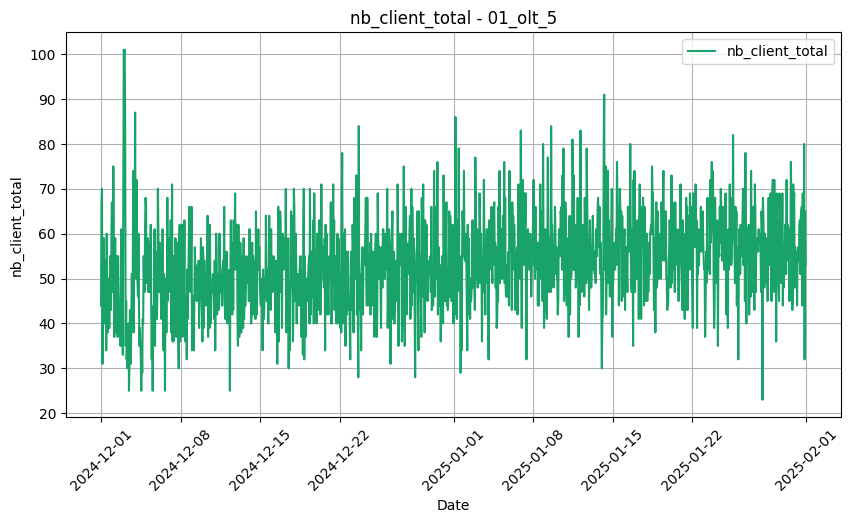

In [72]:
# visualisation d'un OLT
for i, feature in enumerate(col_to_plot):
    plt.figure(figsize=(10, 5))
    plt.plot(df_one_olt['date_hour'], df_one_olt[feature], label=feature, color=col_palette[i])
    
    plt.title(f"{feature} - {olt_choisi}")
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.grid()

    plt.xticks(rotation=45)
    
    plt.show()

On peut supposer que les pics dans les données de variables de test sont associées à des problèmes sur le réseau. Ce sont certainement des anomalies.

Histogrammes (Distribution)

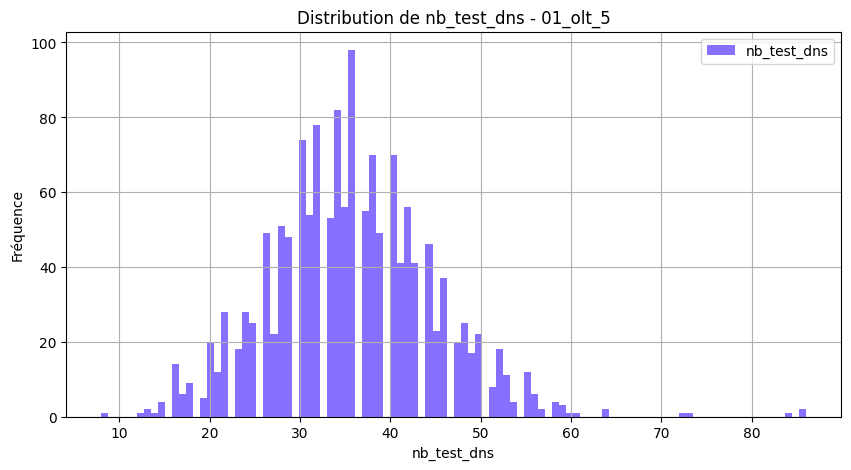

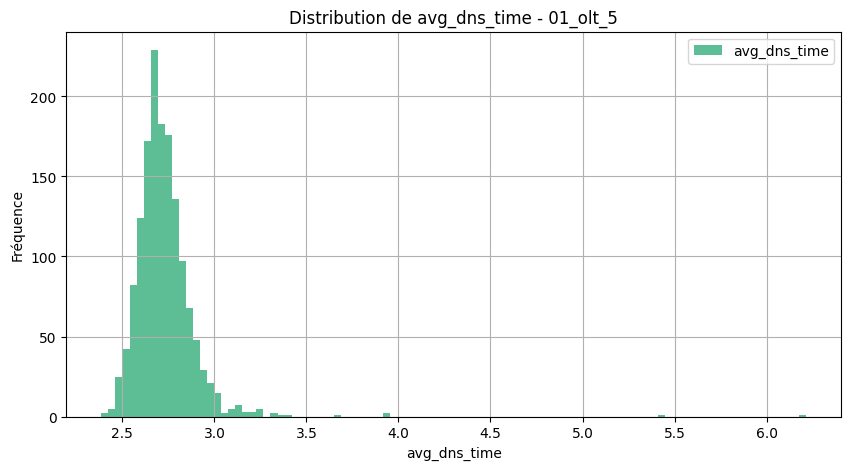

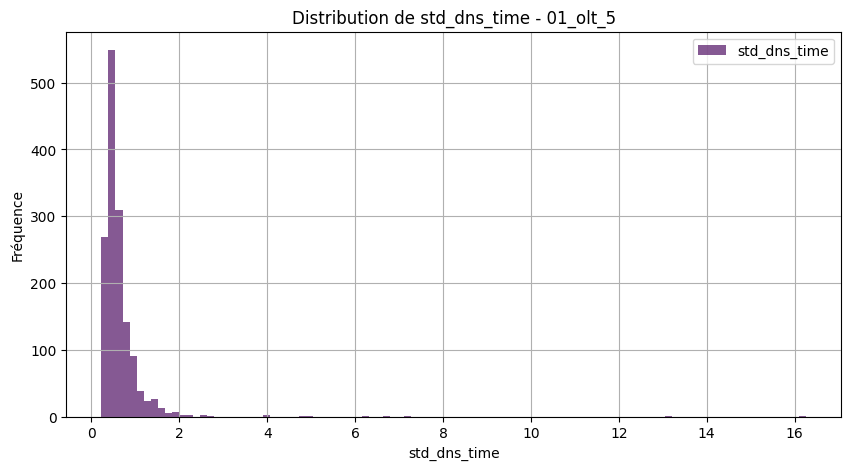

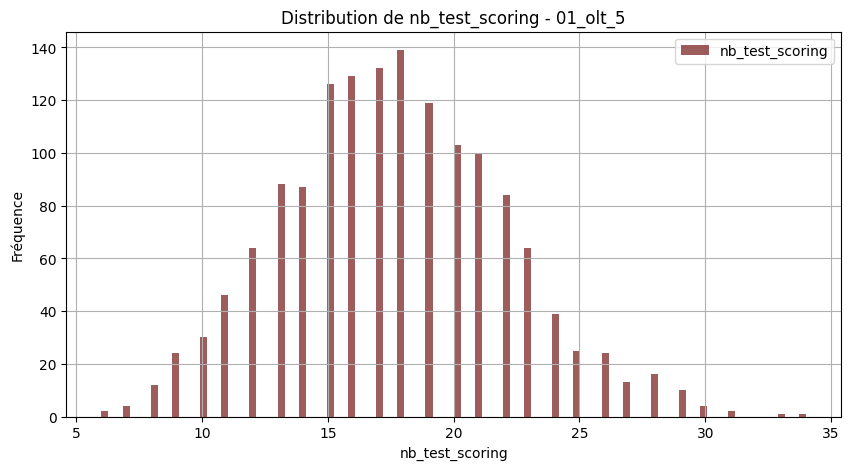

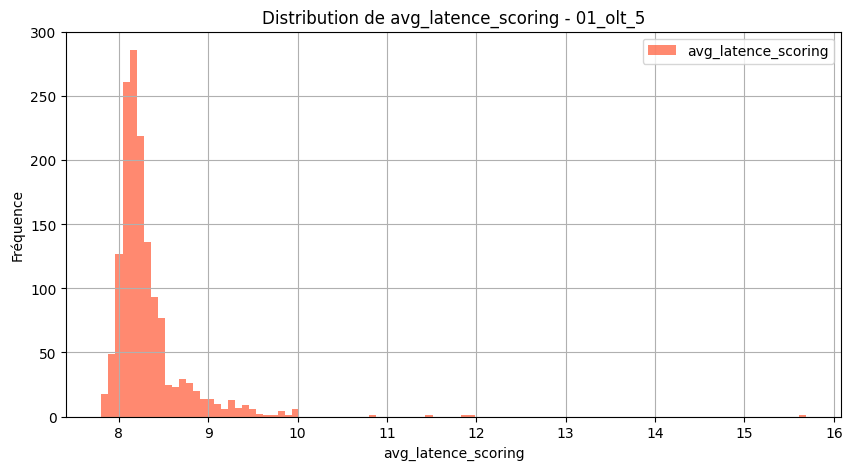

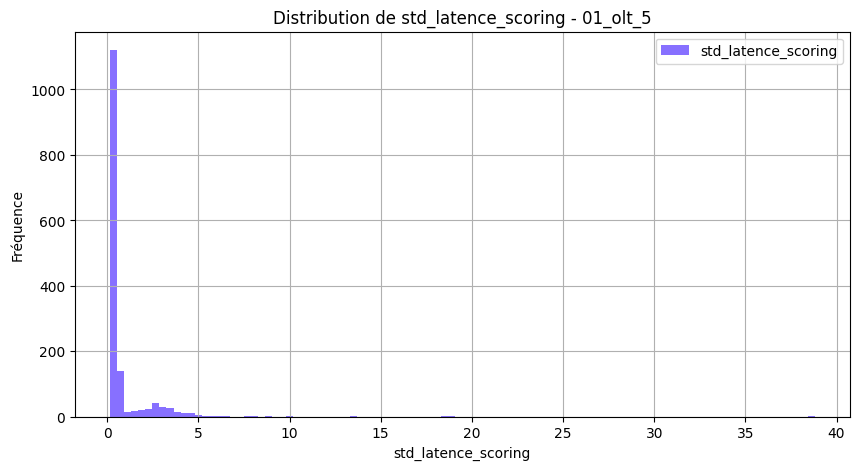

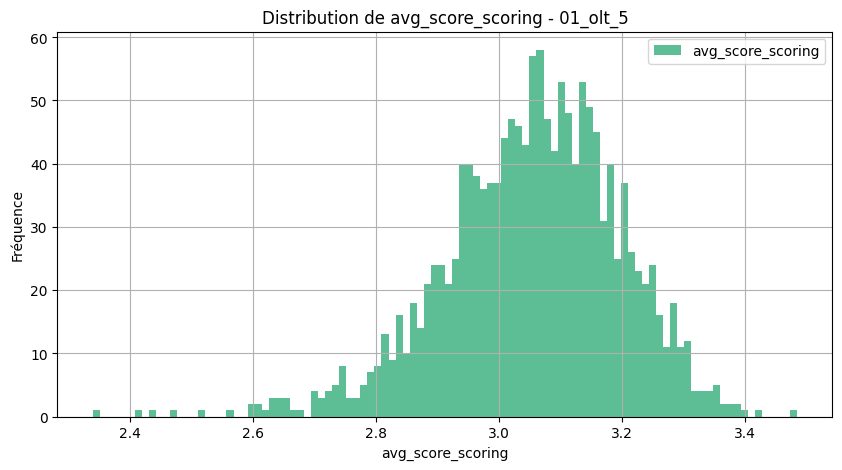

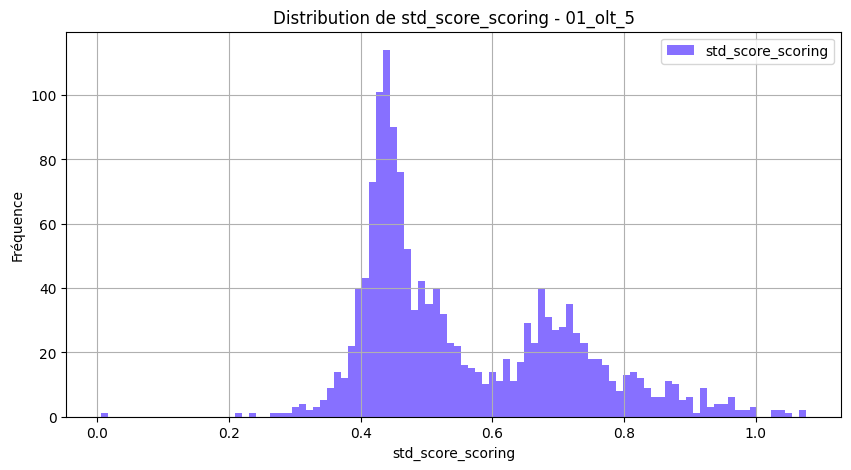

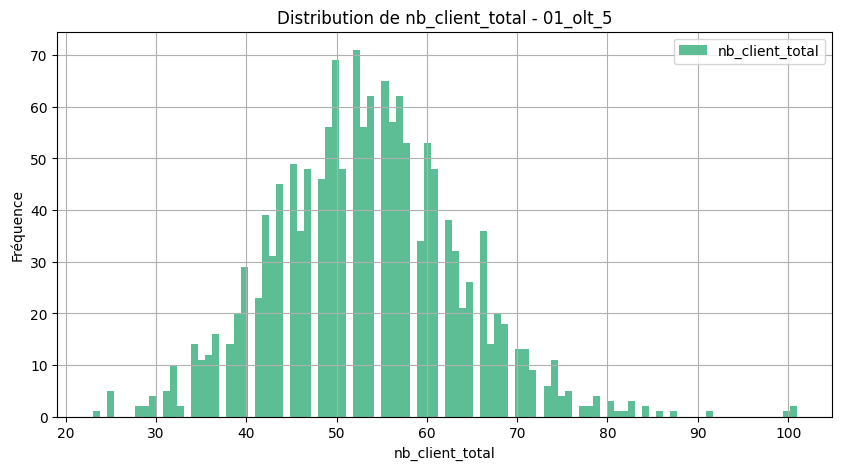

In [73]:
# Visualisation avec des histogrammes
for i, feature in enumerate(col_to_plot):
    plt.figure(figsize=(10, 5))

    plt.hist(df_one_olt[feature], bins=100, color=col_palette[i], alpha=0.7, label=feature)
    

    plt.title(f"Distribution de {feature} - {olt_choisi}")
    plt.xlabel(feature)
    plt.ylabel('Fréquence')
    
    plt.legend()
    plt.grid(True)

    plt.show()

Les valeurs des queues de distribution sont certainement des anomalies